(C:filtre-numerique)=
# Filtres numériques

In [2]:
import numpy as np
from scipy import special
import matplotlib.pyplot as plt
from myst_nb import glue

Les filtres numériques sont très courants et utilisés dans de nombreux domaines :
télécommunications, traitement de la parole, Hi-Fi, radar et sonar, asservissement, vidéo, photos, modem, etc.

S'ils sont à ce point répandus, c'est en raison de leurs nombreux avantages par rapport aux filtres analogiques :
* deux filtres numériques de même configuration sont parfaitement identiques,
* un filtre numérique est facilement reprogrammable,
* l'association de filtres numériques ne pose pas de problème d'impédance,
* il n'y a pas de variation des caractéristiques en fonction de l'âge ou de la température des composants,
* on dispose d'une grande précision de calcul.

En revanche, les filtres numériques sont bien entendu limités par leur fréquence d'échantillonnage
et naturellement inadaptés au traitement du signal analogique.

La réponse impulsionnelle d'un filtre numérique est échantillonnée à une fréquence d'échantillonnage $f_e$.
Dans ce cours, on traitera uniquement des filtres causaux :

$$
h[n] = 0\;\text{si}\; n<0.
$$

Par ailleurs, lorsque la réponse impulsionnelle est à durée limitée, c'est à dire $h[n]=0$ si $n > N$,
alors le filtre est à réponse impulsionnelle finie (RIF).
Dans le cas contraire, on parle de filtre à réponse impulsionnelle infinie (RII).
Ces deux types de filtres sont présentés ci-après, ainsi que deux méthodes de conception :
* la méthode des fenêtres pour les filtres RIF,
* la transformation bilinéaire pour les filtres RII.

## Filtres RIF


### Réponse impulsionnelle

Un filtre RIF a pour réponse impulsionnelle :

$$
h[n] =
\begin{cases}
b_n &\text{si}\, n \in \{0,\dots,N\}, \\
0   &\text{sinon}.
\end{cases}
$$

Sa réponse impulsionnelle est bien finie car elle possède $N+1$ coefficients non nuls :
on dit que le filtre est de longueur $N+1$, ou d'ordre $N$.

### Fonction de transfert

La transformée en Z de $h$ donne la fonction de transfert :

$$
H(z) = \sum_{n=-\infty}^{+\infty} h[n] z^{-n} = \sum_{n=0}^{N} b_n z^{-n}.
$$

Cette fonction de transfert est particulière car elle ne possède pas de pôle,
autrement dit, son dénominateur est égal à 1.
L'absence de pôle est une particularité des filtres RIF,
et comme ils ne risquent pas d'avoir de pôles à l'extérieur du cercle unité, ils sont toujours stables !
Les filtres RIF sont parfois appelés filtres à moyenne mobile ou MA (_moving average_).

### Schéma bloc

Les filtres numériques sont souvent représentés sous forme d'un schéma bloc,
qui illustre graphiquement les relations entre l'entrée et la sortie du filtre.
Pour cela, il convient d'exprimer la sortie en fonction de l'entrée.
Comme on sait que la fonction de transfert $H(z)$ est le rapport entre la sortie sur l'entrée :

$$
H(z) = \frac{Y(z)}{X(z)},
$$

alors :

$$
\sum_{n=0}^{N} b_n z^{-n} = \frac{Y(z)}{X(z)}
\qquad\Leftrightarrow\qquad
Y(z) = \sum_{n=0}^{N} b_n z^{-n} X(z)
$$

dont la transformée en z inverse est, grâce à la propriété de linéarité :

```{margin}
Remarquez qu'on retrouve avec cette formule la formule du produit de convolution !
```

$$
y[n] = \sum_{k=0}^{N} b_k x[n-k].
$$

La sortie $y[n]$ est donc la somme de $N+1$ échantillons d'entrée pondérés par les coefficients $b_k$
et retardés de $k$ échantillons.
On peut donc adopter la représentation suivante, où le bloc $z^{-1}$ indique un retard :


```{figure} _static/figs/filtre-rif.png
:height: 350px
```

Contrairement aux schémas-blocs des filtres RIF que l'on verra plus loin,
il n'y a pas de boucle de retour pour les filtres RIF : on dit qu'ils sont non récursifs.
Par conséquent, la sortie ne peut pas être réinjectée indéfiniment dans le filtre,
empêchant toute instabilité.


### Linéarité de la phase

La linéarité de la phase est souvent un critère souhaité.
Les filtres RIF sont à phase linéaire si leur réponse impulsionnelle et symétrique
(attention, symétrique ne veut pas dire paire ici !) ou antisymétrique, c'est-à-dire :

$$
\forall n\in\{0,\dots,N\}\quad
&h[n] = h[N-1-n]  &\quad\text{pour un filtre symétrique,} \\
&h[n] = -h[N-1-n] &\quad\text{pour un filtre antisymétrique.}
$$

La {numref}`F:num:ri` illustre ces propriétés.

<!-- Démo : Rabiner p. 77 ou Proakis p. 621 -->

```{glue:figure} G:num:ri
:name: "F:num:ri"

Exemples de réponses impulsionnelles symétriques (types I et II) et antisymétriques (types III et IV).
```

Notons que les filtres de type II, III et IV ne sont pas adaptés pour synthétiser des filtres passe-haut.


### Une méthode toute simple pour synthétiser un RIF

<!-- [Méthode des fenêtres](https://vincmazet.github.io/signal2/_static/files/rif.pdf) -->

Une idée toute simple pour obtenir un filtre RIF est de tronquer la réponse impulsionnelle d'un filtre idéal.

Prenons l'exemple d'un filtre passe-bas, et considérons la réponse fréquentielle du filtre idéal, telle qu'on l'a vue dans la section {ref}`S:filtre-intro:pbas` (pour simplifier l'exposé, on prend $K=1$ et $a=0$) :

$$
H_\text{idéal}(f) = \begin{cases}
  1 &\text{si}\, |f| \leq f_c, \\
  0 &\text{si}\, f_c < |f| < \frac{f_e}{2}.
\end{cases}
$$

Remarquez qu'on a ajouté la condition $|f| < \frac{f_e}{2}$ puisque le filtre étant numérique
et d'après le théorème de l'échantillonnage, il n'y a pas de fréquence au delà de la fréquence de Nyquist.

La transformée de Fourier à temps discret inverse de $H(f)$ est un sinus cardinal :

$$
h_\text{idéal}[n] = 2 f_c \mathrm{sinc}(2f_c n).
$$

En ne conservant que $N+1$ échantillons, on obtient forcément un filtre de réponse impulsionnelle finie.
On choisit pour cela de tronquer $h_\text{idéal}$ autour de l'échantillon $n=0$,
et de décaler les échantillons conservés de sorte à rendre le filtre causal.
Ce nouveau filtre a pour réponse impulsionnelle :

$$
h =
\begin{cases}
2 f_c \mathrm{sinc}(2f_c (n-N/2)) &\text{si $n \in \{0,\dots,N\}$} \\
0                               &\text{sinon}.
\end{cases}
$$

```{glue:figure} G:num:fenetre-troncature
:name: "F:num:fenetre-troncature"

Troncature et décalage de la réponse impulsionnelle idéale.
```

Vous noterez que ce filtre est de type I.

Enfin, la transformée de Fourier à temps discret de $h$ nous permet d'obtenir la réponse fréquentielle du filtre.
Son expression est assez complexe et nous ne la détaillons pas ici.
La figure {numref}`F:num:rif-rf` représente le gain de ce filtre RIF construit à partir de la troncature d'un filtre idéal.

```{glue:figure} G:num:rif-rf
:name: "F:num:rif-rf"

Réponse fréquentielle du filtre tronqué et décalé.
```

On observe plusieurs chose sur cette figure :
* la bande de transition n'est pas nulle,
* il y a des oscillations en bande passante et en bande atténuée.

Les oscillations sont d'ailleurs de plus en plus grande lorsqu'on s'approche de la bande de transition :
c'est le phénomène de Gibbs.
Par ailleurs, on remarque que les oscillations ne s'atténuent pas lorsque $N$ augmente,
alors que pourtant le filtre RIF se rapproche de plus en plus du filtre idéal !

L'interprétation que l'on peut faire de ces observations est la suivante.
La troncature revient à multiplier la réponse impulsionnelle $h_\text{idéal}$ par une porte $w[n]$
(on parle de « fenêtrage rectangulaire ») :

$$
h[n] = h_\text{idéal}[n] \times w[n].
$$

Dans le domaine de Fourier, cela revient à convoluer la réponse fréquentielle $H_\text{idéal}$
par la transformée de Fourier à temps discret de $w[n]$ :

$$
H(f) = H_\text{idéal}(f) * \mathcal{F}[w](f),
$$

où la transformée de Fourier à temps discret de $w[n]$ a pour expression :

$$
W(f) = e^{-j \pi f N} \frac{\sin(\pi f(N+1))}{\sin(\pi f)}.
$$

et correspond à la multiplication d'une exponentielle avec un « noyau de Dirichlet » (cf. {numref}`F:num:dirichlet`).

```{glue:figure} G:num:dirichlet
:name: "F:num:dirichlet"

Noyau de Dirichlet, pour deux valeurs de $N$.
```

Ainsi, si le lobe principal du noyau de Dirichlet s'élargit, la bande de transition du filtre va s'élargir également.
Et lorsque les lobes secondaires augmentent,
les oscillations dans les bandes passante et atténuée du filtre vont également s'agrandir.

L'idéal est donc d'avoir un lobe principal étroit et des lobes secondaires faibles.
Il faudrait donc que le noyau de Dirichlet tende vers une impulsion de Dirac,
mais alors cela implique d'augmenter considérablement l'ordre du filtre $N$,
résultant alors dans un filtre à réponse impulsionnelle pas tant finie que ça...

```{margin}
Et oui, en traitement du signal, la porte est un genre de fenêtre !
```

### Méthode des fenêtres

La méthode des fenêtres consiste donc à effectuer la troncature de la réponse impulsionnelle d'un filtre idéal,
où la fenêtre n'est pas forcément une porte.

Le tableau ci-dessous donne les propriétés des réponses fréquentielles obtenues pour plusieurs fenêtres
(la fréquence réduite est la fréquence divisée par $f_e$).

| Fenêtre | Largeur de transition (fréquence réduite) | Ondulation en bande passante (dB) | Atténuation mminimale (dB) |
| :--- | --- | --- | ---: |
| Rectangulaire          | $0,9/N$               | $0,742$             | $21$ |
| Hamming                | $3,3/N$               | $0,019$             | $53$ |
| Blackman               | $5,5/N$               | $0,002$             | $74$ |
| Kaiser ($\beta=4,538$) | $2,93/N$              | $0,0274$            | $50$ |
| Kaiser ($\beta=6,764$) | $4,32/N$              | $0,00275$           | $70$ |
| Kaiser ($\beta=8,960$) | $5,71/N$              | $0,000275$          | $90$ |


```{figure} _static/figs/filtre-fenetres.png
---
width: 500px
name: F:filtre-intro:fenetre
---
Définition des différents éléments de la réponse fréquentielle.
```


<!-- ### Méthode de Remez

La méthode des fenêtres est sous-optimale et donne des ordres de filtres surévalués,
tandis que la méthode de Remez est optimale et fournit le filtre d'ordre minimal satisfaisant le gabarit.

http://eeweb.poly.edu/iselesni/EL713/remez/remez.pdf
https://en.wikipedia.org/wiki/Parks%E2%80%93McClellan_filter_design_algorithm
http://www.ieee.org.ar/downloads/antoniou-nov03.pdf -->

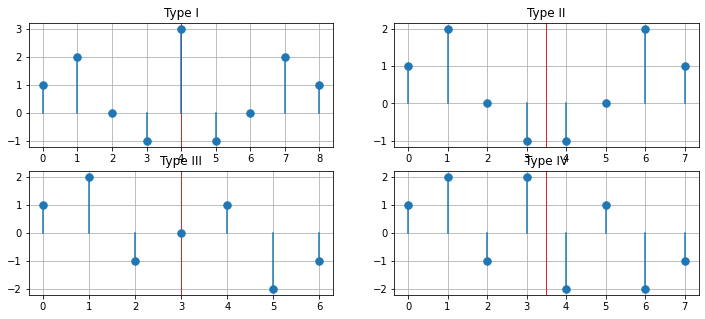

In [78]:
hs = [
    [1, 2, 0, -1, 3, -1, 0, 2, 1],
    [1, 2, 0, -1, -1, 0, 2, 1],
    [1, 2, -1, 0, 1, -2, -1],
    [1, 2, -1, 2, -2, 1, -2, -1]
]
vline = [4, 3.5, 3, 3.5]
types = ["I", "II", "III", "IV"]

fig, axs = plt.subplots(2, 2, figsize=(12,5))
axs = np.ravel(axs)

for i in range(len(hs)):
    
    h = hs[i]
    N = len(h)
    n = np.arange(N)
    axs[i].axvline(vline[i], color="tab:red", linewidth=1, linestyle="-")
    axs[i].plot(n, h, ".", color="tab:blue", markersize=15)
    axs[i].plot([n, n], [np.zeros(N), h], "-", color="tab:blue")
    axs[i].set_title(f"Type {types[i]}")
    axs[i].grid()
    
glue("G:num:ri", fig, display=False)

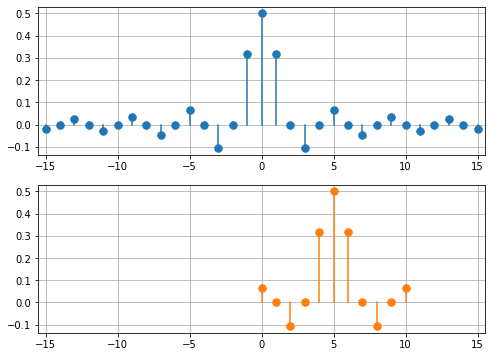

In [79]:
fc = 0.25

# Réponse impulsionnelle idéale
nmax = 15
n = np.arange(-nmax, nmax+1)
h = 2 * fc * np.sinc(2 * fc * n)
N = len(n)

# Réponse impulsionnelle tronquée et causale
mmax = 5
m = np.arange(-mmax, mmax+1)
k = 2 * fc * np.sinc(2 * fc * m)
M = len(k)

# Limites
xlim = [-nmax-.5, nmax+.5]

# Affichage
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6))
ax1.plot(n, h, ".", color="tab:blue", markersize=15)
ax1.plot([n, n], [np.zeros(N), h], "-", color="tab:blue")
ax1.grid()
ax1.set_xlim(xlim)
ax2.plot(m+mmax, k, ".", color="tab:orange", markersize=15)
ax2.plot([m+mmax, m+mmax], [np.zeros(M), k], "-", color="tab:orange")
ax2.grid()
ax2.set_xlim(xlim)

glue("G:num:fenetre-troncature", fig, display=False)

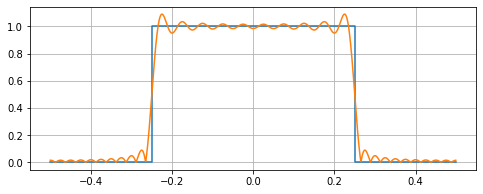

In [82]:
# Filtre idéal
fid = np.array([-.5, -fc, -fc, fc, fc, .5])
Gid = np.array([0, 0, 1, 1, 0, 0])

# TFTD de la réponse impulsionnelle
f = np.arange(-.5, .5, 0.001)
N = 20
H = np.zeros(f.shape, dtype="complex128")
for n in np.arange(-N,N+1):
    H += 2 * fc * np.sinc(2*fc*n) * np.exp(-1j*2*np.pi*f*n)
    
fig = plt.figure(figsize=(8,3))
plt.plot(fid, Gid, "tab:blue")
plt.plot(f, np.abs(H), "tab:orange")
plt.grid()

glue("G:num:rif-rf", fig, display=False)

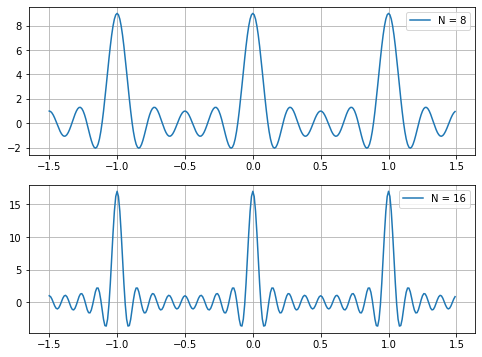

In [81]:
# Noyau de Dirichlet

Ns = [8, 16]
f = np.arange(-1.5, 1.5, 0.01)

fig, ax = plt.subplots(len(Ns), 1, figsize=(8,6))
for i in range(len(Ns)):
    
    N = Ns[i]
    D = (N+1) * special.diric(2*np.pi*f, N+1)
    ax[i].plot(f, D, label=f"N = {N}")
    ax[i].grid()
    ax[i].legend()
    
glue("G:num:dirichlet", fig, display=False)

## Filtres RII

### Réponse impulsionnelle

Un filtre RII a une réponse impulsionnelle qui ne s'annule jamais au délà d'un certain échantillon :

$$
h[n] =
\begin{cases}
c_n &\text{si}\, n \geq 0, \\
0   &\text{sinon}.
\end{cases}
$$

### Fonction de transfert

La fonction de transfert d'un filtre RII est de la forme:

$$
H(z) = \frac{ \sum_{m=0}^M b_m z^{-m} }{ \sum_{n=0}^N a_n z^{-n} }.
$$

Les filtres RII sont parfois appelés filtres ARMA car la fonction de transfert est le quotient entre :
* un numérateur correspondant à un filtre MA (on l'a vu plus haut),
* et un dénominateur correspondant à un filtre appelé AR (_autoregressive_).

### Schéma bloc

Comme pour les filtres RIF, il est possible de représenter les filtres RII sous forme d'un schéma bloc.
À partir de la fonction de transfert, on peut écrire la sortie en fonction de l'entrée :

$$
H(z) = \frac{Y(z)}{X(z)} = \frac{ \sum_{m=0}^M b_m z^{-m} }{ \sum_{n=0}^N a_n z^{-n} }
\qquad\Leftrightarrow\quad
\sum_{k=0}^N a_k z^{-k} Y(z) = \sum_{l=0}^M b_l z^{-l} X(z).
$$

d'où, en utilisant la transformée en z inverse :

$$
\sum_{k=0}^N a_k y[n-k] = \sum_{l=0}^M b_l x[n-l].
$$

On peut alors isoler $y[n]$ et l'écrire en fonction des autres termes :

$$
y[n] = \frac{1}{a_0} \left( \sum_{l=0}^M b_l x[n-l] - \sum_{k=1}^N a_k y[n-k] \right).
$$

La sortie $y[n]$ est donc la somme de $M+1$ échantillons d'entrée pondérés et retardés
et de $N$ échantillons de la sortie pondérés et retardés,
le tout multiplié par $\frac{1}{a_0}$.
On peut donc représenter graphiquement cette équation (rappel : le bloc $z^{-1}$ indique un retard) :


```{figure} _static/figs/filtre-rii.png
:height: 350px
```

Remarquez qu'à l'inverse des filtres RIF, les filtres RII possèdent une boucle de retour (partie récursive).
À cause de cette boucle, les filtres RII peuvent être instables :
le signal étant indéfiniment réinjecté dans le filtre, la sortie peut être de plus en plus grande.


### Transformation bilinéaire

La transformation bilinéaire est la méthode la plus simple pour concevoir un filtre RII.
Elle s'applique sur un filtre analogique pour le transformer en filtre numérique.
De ce fait, l'application de la transformation bilinéaire suit les étapes suivantes :

1. À partir du gabarit numérique, une transformation sur les fréquences permet d'obtenir un gabarit analogique.
1. Un filtre analogique est conçu à partir de ce gabarit analogique.
1. Une transformation sur la fonction de transfert du filtre analogique
   permet d'obtenir la fonction de transfert du filtre numérique.
   
Plus formellement, le passage du domaine analogique au domaine numérique
transforme l'axe des imaginaires du plan en $s$ en le cercle unité du plan en $z$ (cf. {numref}`F:num:tbilin`).
Ainsi, la stabilité est conservée puisque les pôles à partie réelle négative du plan en $s$
se retrouvent dans le cercle unité du plan en $z$.

```{figure} _static/figs/tbilin.png
---
height: 200px
name: F:num:tbilin
---
Transformée bilinéaire.
```

La transformation bilinéaire est reliée aux équations suivantes :

$$
s = \frac{2}{T_e} \left(\frac{1-z^{-1}}{1+z^{-1}}\right)
\qquad\Leftrightarrow\qquad
z = \frac{1+T_e/2s}{1-T_e/2s}.
$$

où $T_e$ est la période d'échantillonnage.
Donc, la fonction de transfert numérique $H_n(z)$ s'obtient à partir de la la fonction de transfert analogique $H_a(s)$
grâce à la relation suivante :

$$
H_n(z) = H_a\left(\frac{2}{T_e} \left(\frac{1-z^{-1}}{1+z^{-1}}\right)\right).
$$

Par ailleurs, on montre que la transformation à appliquer sur l'axe des fréquences du gabarit numérique est :

$$
f_a = \frac{1}{\pi T_e} \tan\left(\pi\frac{f_n}{f_e}\right).
$$

où $f_a$ et $f_n$ sont respectivement les fréquences des gabarits analogique et numérique,
et $f_n/f_e$ est la fréquence réduite (avec $f_e=1/T_e$).

<!-- Lorsque l'ordre des filtres augmente (c'est-à-dire lorsque le nombre de coefficients augmentent) le filtre peut devenir instable à cause de la quantification des coefficients point. Une solution consiste à remplacer le filtre par une série de filtres d'ordre faible (un ou 2) 

Filtres, bi-quad, biquadratique 

SOS s order section 
 -->
